# Algorytmy macierzowe - zadanie nr 3 - Formaty macierzy rzadkich

" Proszę wybrać swój ulubiony język programowania. Proszę wziąć największe macierze, które używali Państwo w zadaniu pierwszym (ewentualnie zmniejszyć p żeby stały się rzadsze). Proszę przekonwertować je do stosownego formatu i przemnożyć
przez siebie.

6. Pierwsza i druga macierz CSR format "

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [190]:
import numpy as np
from time import time
import pandas as pd
import os
from time import time

## Generowanie macierzy

In [191]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [192]:
# 441 x 441 matrix
A = read_matrix("matrices/riga_10.txt")
B = A.copy()

In [193]:
matrices  = []
for file in os.listdir('matrices'):
    if file.startswith('riga'):
        matrices.append(read_matrix('matrices/' + file))

## Mnożenie macierzy z zadania 1

In [194]:
def mm_ipj(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for i in range(m):
        for p in range(n):
            for j in range(k):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

In [195]:
start = time()
mm_ipj(A, B)
end = time()
print("Czas mnożenia : ",end - start)

Czas mnożenia :  1.6618833541870117


## Format CSR

In [196]:
def convert_to_csr(matrix):
    m, n = matrix.shape
    ICL = []
    VAL = []
    ROWPTR = []
    counter = 0
    for i in range(n): # rows
        ROWPTR.append(counter)
        for j in range(m): # columns
            val_ij = matrix[i,j]
            if abs(val_ij) < 1e-8:
                continue
            ICL.append(j)
            VAL.append(val_ij)
            counter += 1
    ROWPTR.append(counter)
    
    return ICL, VAL, ROWPTR

In [197]:
A_csr = convert_to_csr(A)
B_csr = convert_to_csr(B)

## Mnożenie macierzy CSR

In [198]:
def get_ICL_VAL_from_dict(C_ROW):
    C_ROW_sorted = sorted(C_ROW.items(), key=lambda item : item[0]) # sorting by key (column index)
    ICL_C = [x[0] for x in C_ROW_sorted] # column indexes list
    VAL_C = [x[1] for x in C_ROW_sorted] # values list
    return ICL_C, VAL_C
    
def matmul_CSR(A, B):
    ICL_A, VAL_A, ROWPTR_A = A
    ICL_B, VAL_B, ROWPTR_B = B    
    ICL_C, VAL_C, ROWPTR_C = [], [], []

    elements_counter = 0
    for i in range(len(ROWPTR_A) - 1): # rows in A
        row_a_start_idx = ROWPTR_A[i]
        row_a_end_idx = ROWPTR_A[i+1]
        C_ROW = dict() # dict to store results of row_A * rows_B
        for j in range(row_a_start_idx,row_a_end_idx): # indexes of values in row A
            col_a = ICL_A[j]
            val_a = VAL_A[j]
            row_b_start_idx = ROWPTR_B[col_a] # column idx in A maps to row idx in B
            row_b_end_idx = ROWPTR_B[col_a + 1] # col_a + 1 to get range of value indexes in B row
            for p in range(row_b_start_idx,row_b_end_idx): # indexes of values in row B
                col_b = ICL_B[p]
                val_b = VAL_B[p]
                C_ROW[col_b] = C_ROW.get(col_b, 0) + (val_a * val_b) # update dict with val_a * val_b
                
        ICL, VAL = get_ICL_VAL_from_dict(C_ROW)
        ICL_C += ICL
        VAL_C += VAL
        ROWPTR_C.append(elements_counter)
        elements_counter += len(VAL)
    
    ROWPTR_C.append(elements_counter)
    return ICL_C, VAL_C, ROWPTR_C

In [199]:
start = time()
matmul_CSR(A_csr, B_csr)
end = time()
print("Czas mnożenia : ",end - start)

Czas mnożenia :  0.02394723892211914


## Test poprawności mnożenia CSR * CSR

In [200]:
def print_CSR_matrix(A):
    ICL, VAL, ROWPTR = A
    VAL = VAL.copy()
    m_col = max(ICL) + 1
    for i in range(len(ROWPTR)-1):
        for p in range(m_col):
            if p in ICL[ROWPTR[i]:ROWPTR[i+1]]:
                print(VAL.pop(0), end=",")
            else:
                print(0, end=",")
        print("\n")

In [201]:
testA = np.array([[0,0,1],
                  [0,0,0],
                  [3,1,4]])
testB = np.array([[0,0,1],
                  [0,0,0],
                  [3,1,4]])

testA_csr = convert_to_csr(testA)
testB_csr = convert_to_csr(testB)

print("Format CSR \n ICL : {} \n VAL : {}\n ROWPTR : {}".format(*testA))

Format CSR 
 ICL : [0 0 1] 
 VAL : [0 0 0]
 ROWPTR : [3 1 4]


In [202]:
print("Wynikowa macierz (zwykłe mnożenie)\n")
print(testA @ testB)

Wynikowa macierz (zwykłe mnożenie)

[[ 3  1  4]
 [ 0  0  0]
 [12  4 19]]


In [203]:
testC = matmul_CSR(testA_csr, testB_csr)
print("Wynikowa macierz (mnożenie CSR)\n")
print_CSR_matrix(testC)

Wynikowa macierz (mnożenie CSR)

3,1,4,

0,0,0,

12,4,19,



## Pomiar czasów

In [204]:
def compare_times(matrices):
    times = {}
    
    for matrix in matrices:
        size = matrix.shape[0]
        times[size] = {}
        start = time()
        mm_ipj(matrix, matrix)
        times[size]["matmul_ijp"] = time() - start
        
        matrix_csr = convert_to_csr(matrix)
        start = time()
        matmul_CSR(matrix_csr, matrix_csr)
        times[size]["matmul_csr"] = time() - start

    df = pd.DataFrame(times).T.sort_index()
    df.plot(
        figsize=(13, 10),
        xlabel='matrix size (n x n)',
        ylabel='time [s]',
        colormap='Accent',
        linewidth=3,
        markersize=10,
        marker='o'
    )
          
    return df

,matmul_ijp,matmul_csr
144,1.601351,0.021941
256,9.489136,0.043880
484,71.104872,0.096742
900,453.509410,0.201465


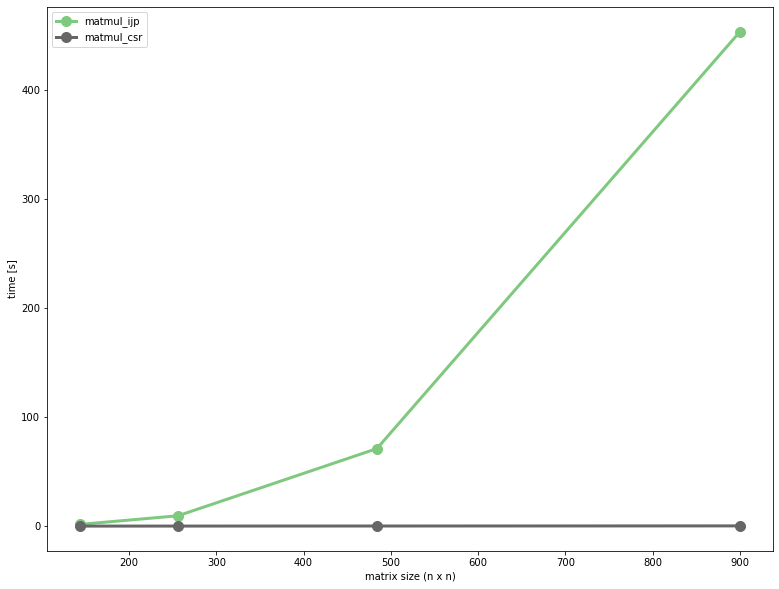

In [205]:
compare_times(matrices)

## Wnioski

* 
* 

M. Hawryluk, N. Wolniak. 2021